In [1]:
import numpy as np, pennylane as qml, torch, matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor
from timeit import default_timer


def CliffordRX(angle: int, wires: "qml.Wires"):
    """
    Returns the exp(-i theta/2 X) operator,
    for theta ∈ {0, pi/2, pi, 3pi/2},
    decomposed into basis operators accepted by the
    qml 'default.clifford' device.

    Args:
        integer_angle (int): theta / (pi/2)
    """
    if not isinstance(angle, (int, np.integer)):
        print(type(angle))
        raise TypeError(f"angle = {angle} should be integer")
    if angle % 4 == 0:
        #qml.I(wires)
        return
    elif angle % 4 == 1:
        qml.adjoint(qml.S(wires))
        qml.H(wires)
        qml.adjoint(qml.S(wires))
    elif angle % 4 == 2:
        qml.X(wires)
    elif angle % 4 == 3:
        qml.S(wires)
        qml.H(wires)
        qml.S(wires)

def CliffordRY(angle: int, wires: "qml.Wires"):
    if not isinstance(angle, (int, np.integer)):
        print(type(angle))
        raise TypeError(f"angle = {angle} is of type {type(angle)}. It should be integer")
    if angle % 4 == 0:
        #qml.I(wires)
        return
    elif angle % 4 == 1:
        qml.H(wires)
        qml.X(wires)
    elif angle % 4 == 2:
        qml.Y(wires)
    elif angle % 4 ==3:
        qml.X(wires)
        qml.H(wires)

def random_angles(size: int | list[int]) -> np.ndarray:
    possible_thetas = np.arange(4)
    return np.random.choice(possible_thetas, size)

def unit_vector(index: int, size: int):
    return np.array([
        1 if _ == index else 0
        for _ in range(size)
    ])

def basis_encoding(x: int, wires: "qml.Wires"):
    xbin = np.binary_repr(x, wires.__len__())
    for i in range(len(wires)):
        if xbin[i] == '1':
            qml.X(wires[i])

def simple_test_circuit(angles: list[int], wires: "qml.Wires"):
    n_qubits = len(angles)
    for i in range(n_qubits):
        CliffordRX(angles[i], wires[i])

def sum_of_expvals(f):
    """
    Decorator to make quantum functions return a sum of measured operators rather than
    an array of them.
    """
    def wrapper(*args, **kwargs):
        return np.sum(f(*args, **kwargs))
    return wrapper

def parameter_shift_rule_gradient(f: "function", angles: np.ndarray[int], *args, **kwargs):
    out = np.empty_like(angles)
    for i in np.ndindex(angles.shape):
        original_angle = angles[i]  # Will need to be restored at the end of loop
        angles[i] += 1
        f_plus = f(angles, *args, **kwargs)
        angles[i] -= 2
        f_minus = f(angles, *args, **kwargs)
        angles[i] = original_angle
        out[i] = (f_plus - f_minus) / 2
    return out

def empirical_NTK(f: "function", angles: np.ndarray[int], x, y):
    return np.sum(
        parameter_shift_rule_gradient(f, angles, x)
        *
        parameter_shift_rule_gradient(f, angles, y)
    )

def analytic_NTK(f: "function", x, y, angles_shape: tuple[int], n_shots: int):
    return np.mean([
        empirical_NTK(
            f, random_angles(angles_shape), x, y
        )
        for _ in range(n_shots)
    ])

def elementary_2_qubit_gate(angles: np.ndarray[int], wires: "qml.Wires"):
    if np.shape(angles) != (4,):
        raise ValueError(f"angles has shape {np.shape(angles)}. It should be (4,)")
    if len(wires) != 2:
        raise ValueError(f"This gate acts on 2 qubits, but {len(wires)} wires were provided.")
    #print(wires)
    CliffordRX(angles[0], wires[0])
    CliffordRX(angles[1], wires[1])
    qml.CNOT([wires[0], wires[1]])
    CliffordRY(angles[2], wires[0])
    CliffordRY(angles[3], wires[1])


def layer(angles: np.ndarray[int], wires: "qml.Wires"):
    if np.shape(angles) != (4, 21):
        raise ValueError(f"angles has shape {np.shape(angles)}. It should be (4,21)")
    if len(wires) != 10:
        raise ValueError(f"This gate acts on 10 qubits, but {len(wires)} wires were provided.")
    
    i = 0
    def eg(wires):
        nonlocal i
        elementary_2_qubit_gate(angles[:, i], wires)
        i+=1
    
    eg([wires[8], wires[9]]); eg([wires[6], wires[7]])
    eg([wires[7], wires[9]]); eg([wires[6], wires[8]])
    eg([wires[8], wires[9]]); eg([wires[6], wires[7]]); eg([wires[4], wires[5]])
    eg([wires[5], wires[7]]); eg([wires[4], wires[6]])
    eg([wires[6], wires[7]]); eg([wires[4], wires[5]]); eg([wires[2], wires[3]])
    eg([wires[3], wires[5]]); eg([wires[2], wires[4]])
    eg([wires[4], wires[5]]); eg([wires[2], wires[3]]); eg([wires[0], wires[1]])
    eg([wires[1], wires[3]]); eg([wires[0], wires[2]])
    eg([wires[2], wires[3]]); eg([wires[0], wires[1]])

def paolo_circuit(angles: np.ndarray[int], wires):
    if np.shape(angles) != (4, 21, 3):
        raise ValueError(f"angles has shape {np.shape(angles)}. It should be (4,21,3)")
    for i in range(3):
        #print(f"Building layer {i}")
        layer(angles[:,:,i], wires)
        qml.I(wires[0])

def get_image(idx: int, dataset):
    image, label = dataset[idx]
    padded_image = torch.zeros([32, 32])
    padded_image[:28, :28] = image.squeeze()[:, :]
    return padded_image

def img_to_vec(image: torch.Tensor):
    n = int(np.log2(image.shape[0]))  # Image should be a 2^n x 2^n tensor
    image = image.reshape([2 for i in range(2*n)])  # Convert tensor indices from y,x to y0,y1,...,yn-1,x0,x1,...,xn-1
    image = image.permute([i+j for i in range(n) for j in [0, n]])  # Permute indices from y0,y1,...,yn-1,x0,x1,...,xn-1 to y0,x0,y1,x1,...,yn-1,xn-1
    return image.flatten()



In [5]:
wires = [f"{letter}{i}" for i in range(5) for letter in ["y", "x"]]
dev = qml.device('lightning.qubit', wires = wires)

@sum_of_expvals
@qml.qnode(dev)
def paolo_f(angles, image):
    qml.AmplitudeEmbedding(
        img_to_vec(image), dev.wires, normalize=True
    )

    #qml.Snapshot("Encoded state")
    paolo_circuit(angles, dev.wires)
    ops = [qml.expval(qml.Z(wire)) for wire in dev.wires]
    return ops


mnist_train = datasets.MNIST("./data",
                             train= True,
                             transform= ToTensor(),
                             download= True)

In [ ]:
"""
To compute the NTK(img1, img2) between two images, you should run the following code.
Note however than computing NTK(img1, img2) for a single pair of images on a single shot takes ~40 seconds on default.qubit
and ~25 seconds on lightning.qubit,
making computation of NTK(mnist_train, mnist_train^T) for many shots unfeasible.
"""
img1, img2 = get_image(0, mnist_train), get_image(1, mnist_train)
ntk = analytic_NTK(paolo_f, img1, img2, angles_shape=[4,21,3], n_shots=1)

In [ ]:
np.float32(
    25 * 100**2 / 2
)

np.float32(125000.0)

In [12]:
10**6 / (60 * 60 * 24)

11.574074074074074

In [ ]:


img = get_image(0, mnist_train)
img.shape

torch.Size([32, 32])

In [7]:
start_time = default_timer()
paolo_f(random_angles([4,21,3]), img)
end_time = default_timer()
time = end_time - start_time
time

0.04738991299927875

In [8]:
4*21*3

252

In [16]:
np.log10(1*252*4 * 60e3**2 * 10)

np.float64(13.559763032876793)

In [ ]:
analytic_NTK(
    paolo_f, img, img,
    [4, 21, 3],
    1
)

np.float64(0.0)

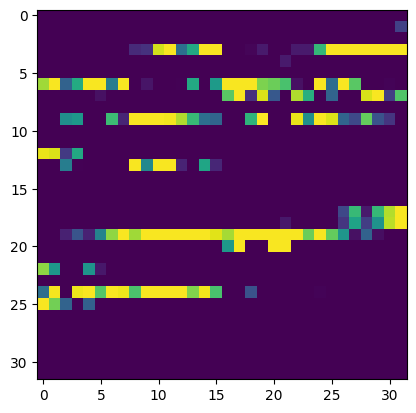

In [12]:
plt.imshow(
    img.reshape(
        [2 for _ in range(10)]
        ).permute(
            [i + j for i in range(5) for j in [0,5]]
        ).reshape(
            32, 32
        )
)

In [20]:
angles = random_angles([4, 21, 3])
paolo_f(angles, img)

np.float64(0.08691675758502915)